# Milestone2: 

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
pd.set_option('display.max_columns', None)

### Loading the data

In [3]:
# Milestone 2 (Classification): Data Exploration#1. Use different unsupervised techniques (eg. hierarchical clustering) and statistical tests to get correlations across radiological descriptions and also detect those annotations more relevant to the diagnosis.
# We import the data from the directory where it is saved in our computer
# dirname = "C:\\Users\\sansg\\Downloads\\MetadatabyNoduleMaxVoting.xlsx"
meta = "MetadatabyNoduleMaxVoting.xlsx"

df = pd.read_excel(meta)
print("✅ Data imported! Printing the first 5 elements")
df.head(5)


✅ Data imported! Printing the first 5 elements


,patient_id,nodule_id,seriesuid,coordX,coordY,coordZ,diameter_mm,bboxLowX,bboxLowY,bboxLowZ,bboxHighX,bboxHighY,bboxHighZ,Diagnosis,Diagnosis_value,Malignancy,Malignancy_value,Calcification,Calcification_value,InternalStructure,InternalStructure_value,Lobulation,Lobulation_value,Margin,Margin_value,Sphericity,Sphericity_value,Spiculation,Spiculation_value,Subtlety,Subtlety_value,Texture,Texture_value,len_mal_details
0,LIDC-IDRI-0001,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,56.208405,86.343413,-115.867579,23.350644,43.531250,68.768753,-125.0,70.953125,101.112503,-107.50,Malign,1,Highly Suspicious,5,Absent,6,Soft Tissue,1,Medium Lobulation,3,Near Sharp,4,Ovoid,3,Marked Spiculation,5,Obvious,5,Solid,5,4
1,LIDC-IDRI-0003,2,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,72.286707,76.900239,-190.458928,21.453729,57.488893,63.984216,-199.0,87.020126,91.054513,-184.00,Malign,1,Highly Suspicious,5,Absent,6,Soft Tissue,1,Nearly No Lobulation,2,Medium Margin,3,Ovoid/Round,4,Nearly No Spiculation,2,Obvious,5,Solid/Mixed,4,4
2,LIDC-IDRI-0003,3,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,23.490831,-47.633906,-172.279142,8.785833,17.293604,-51.679780,-176.5,30.418596,-42.656347,-169.00,Malign,1,Moderately Suspicious,4,Absent,6,Soft Tissue,1,No Lobulation,1,Near Sharp,4,Ovoid/Linear,2,No Spiculation,1,Fairly Subtle,3,Solid,5,4
3,LIDC-IDRI-0003,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,-47.402846,-30.171209,-169.623946,12.823120,-54.893854,-37.734475,-174.0,-40.128238,-22.968859,-164.00,Malign,1,Moderately Unlikely,2,Absent,6,Soft Tissue,1,No Lobulation,1,Sharp,5,Ovoid/Round,4,No Spiculation,1,Moderately Obvious,4,Solid,5,4
4,LIDC-IDRI-0004,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...,-118.051233,94.754141,-230.190551,4.560710,-121.327297,91.802848,-232.5,-115.571436,98.380976,-228.75,Benign,0,Highly Unlikely,1,Solid,3,Soft Tissue,1,No Lobulation,1,Sharp,5,Ovoid/Linear,2,No Spiculation,1,Moderately Subtle,2,Solid,5,4


# Please verify this: 

I think each row in the excel is a different nodule. Grouping the data by patient does not make much sense to me, we want to train the classifier per nodule, and a single patient can have multiple nodules, some bening, some malign.

In [4]:
# max_voting = df.groupby(['patient_id']).agg(lambda x: x.mode()[0]).reset_index()
# print("✅ Data imported and grouped by patient! Printing the first 5 elements")
# max_voting.head(5)

In [5]:
# max_voting.shape

In [6]:
df.shape

(996, 34)

In [7]:
# Some statistical analysis before implementing unsupervised techniques
df.info()
print("Number of cases per", df.groupby('Diagnosis').size())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               996 non-null    object 
 1   nodule_id                996 non-null    int64  
 2   seriesuid                996 non-null    object 
 3   coordX                   996 non-null    float64
 4   coordY                   996 non-null    float64
 5   coordZ                   996 non-null    float64
 6   diameter_mm              996 non-null    float64
 7   bboxLowX                 996 non-null    float64
 8   bboxLowY                 996 non-null    float64
 9   bboxLowZ                 996 non-null    float64
 10  bboxHighX                996 non-null    float64
 11  bboxHighY                996 non-null    float64
 12  bboxHighZ                996 non-null    float64
 13  Diagnosis                996 non-null    object 
 14  Diagnosis_value          9

We have 650 Benign and 346 Malign tumors in the dataset

In [8]:
# dropping the text columns, the label columns and the location columns
df_filtered = df.drop(['nodule_id','patient_id','seriesuid', 'Diagnosis', 'coordX', 'coordY', 'coordZ', 'bboxLowX', 'bboxLowY', 'bboxLowZ', 'bboxHighX','bboxHighY','bboxHighZ','Diagnosis_value', 'Malignancy', 'Malignancy_value','Calcification', 'InternalStructure', 'Lobulation', 'Margin', 'Sphericity', 'Spiculation', 'Subtlety', 'Texture'], axis = 1)
print("✅ Data filtered! Printing the first 5 elements")


print("Count of missing values in each column:\n", df_filtered.isnull().sum())
print("✅ No missing values on the data!")
df_filtered.head(20)

✅ Data filtered! Printing the first 5 elements
Count of missing values in each column:
 diameter_mm                0
Calcification_value        0
InternalStructure_value    0
Lobulation_value           0
Margin_value               0
Sphericity_value           0
Spiculation_value          0
Subtlety_value             0
Texture_value              0
len_mal_details            0
dtype: int64
✅ No missing values on the data!


,diameter_mm,Calcification_value,InternalStructure_value,Lobulation_value,Margin_value,Sphericity_value,Spiculation_value,Subtlety_value,Texture_value,len_mal_details
0,23.350644,6,1,3,4,3,5,5,5,4
1,21.453729,6,1,2,3,4,2,5,4,4
2,8.785833,6,1,1,4,2,1,3,5,4
3,12.823120,6,1,1,5,4,1,4,5,4
4,4.560710,3,1,1,5,2,1,2,5,4
5,5.317166,6,1,1,5,5,1,3,5,4
6,6.133374,6,1,1,5,5,1,3,5,4
7,6.706615,6,1,2,4,3,1,3,4,4
8,22.880792,6,1,1,3,4,5,5,5,4
9,5.687247,6,1,1,2,3,1,3,1,3


In [9]:
df_filtered.shape

(996, 10)

### Visualizing the data on a boxplot

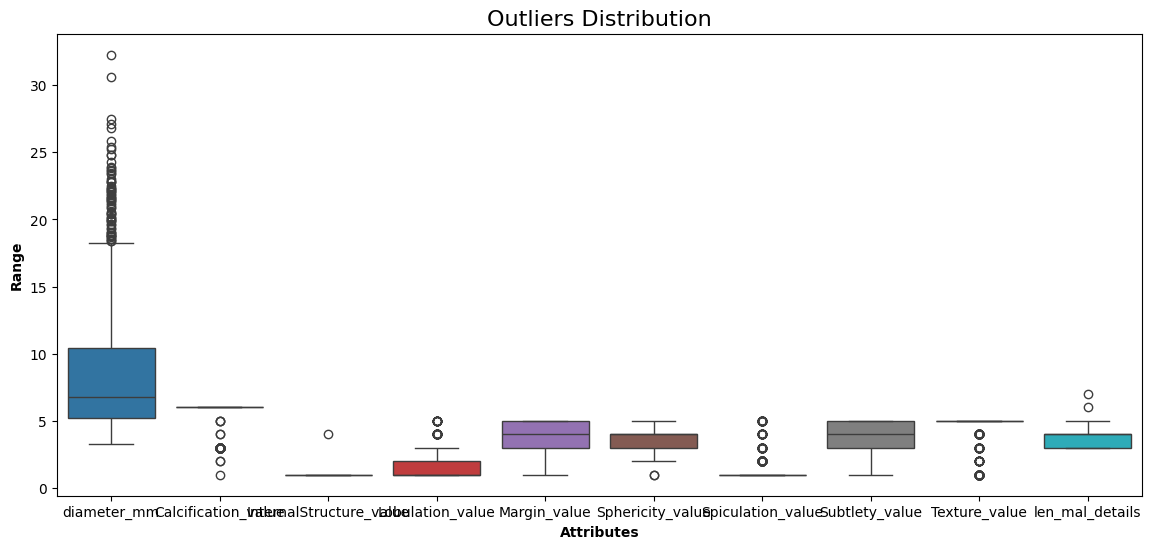

In [10]:
def show_boxplot(df):
    plt.rcParams['figure.figsize'] = [14,6]
    sns.boxplot(data = df, orient="v")
    plt.title("Outliers Distribution", fontsize = 16)
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')
show_boxplot(df_filtered)

### Tsne - exploring class separability

In [11]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
df_filtered2 = df_filtered.copy()
scaler = MinMaxScaler(feature_range=(1, 6))  # Scale to match categorical values
# df_filtered2['diameter_mm'] = scaler.fit_transform(df_filtered2[['diameter_mm']])

In [12]:
df_filtered2.head()

,diameter_mm,Calcification_value,InternalStructure_value,Lobulation_value,Margin_value,Sphericity_value,Spiculation_value,Subtlety_value,Texture_value,len_mal_details
0,23.350644,6,1,3,4,3,5,5,5,4
1,21.453729,6,1,2,3,4,2,5,4,4
2,8.785833,6,1,1,4,2,1,3,5,4
3,12.823120,6,1,1,5,4,1,4,5,4
4,4.560710,3,1,1,5,2,1,2,5,4


We have quite a lot of outliers. Let's check with tnse if we have separable classes in the data:

In [13]:
from sklearn.manifold import TSNE,trustworthiness

In [14]:
#tsne_default = fast_tsne(X_scaled, perplexity=30, seed=42)
tsne = TSNE(n_components=2,perplexity=70, random_state=41)
tsne_default = tsne.fit_transform(df_filtered2)
#Trustworthiness of the low-dimensional space compared to the high dimensional space [0,1]
Trst=trustworthiness(df_filtered2, tsne_default)
Trst

np.float64(0.9901435702323463)

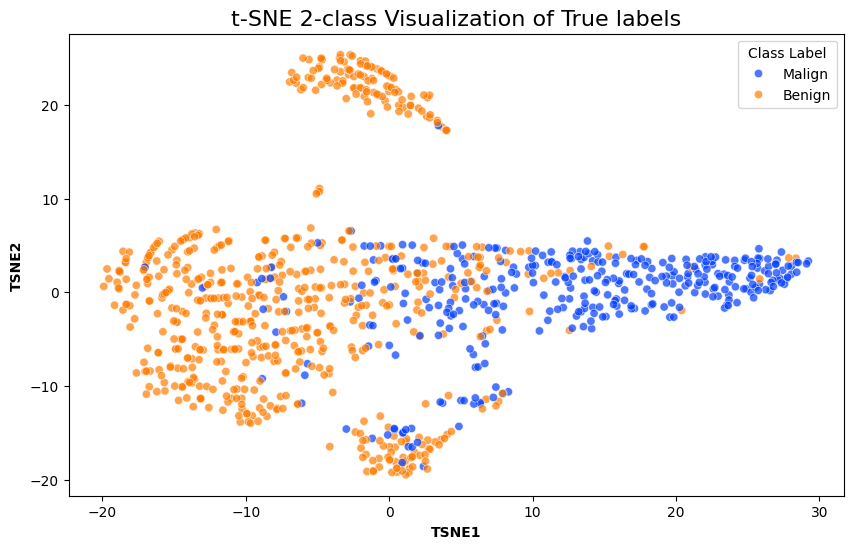

In [94]:
# Convert t-SNE results into a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_default, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = df['Diagnosis']  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 2-class Visualization of True labels", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

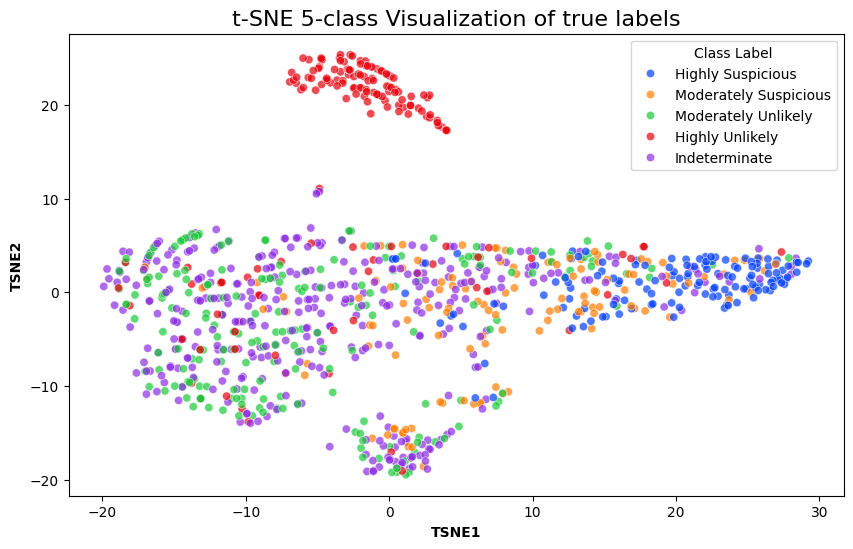

In [93]:
# Convert t-SNE results into a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_default, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = df['Malignancy']  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 5-class Visualization of true labels", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

We can clearly see some level of separation: ,,highly unlikely-s" are possibly easy to distinguish from the rest, malign tumors are located more on the right. I'm not sure if this will be enough for unsupervised classifiers. I try to one-hot encode the cathegorical features to see my results.

### One-hot encoding cathegorical features

In [17]:
df_filtered3 = df_filtered.copy()

In [18]:
df_filtered3.columns

Index(['diameter_mm', 'Calcification_value', 'InternalStructure_value',
       'Lobulation_value', 'Margin_value', 'Sphericity_value',
       'Spiculation_value', 'Subtlety_value', 'Texture_value',
       'len_mal_details'],
      dtype='object')

In [19]:
df_cat = df_filtered3.drop("diameter_mm", axis = 1)
df_cat.head()

,Calcification_value,InternalStructure_value,Lobulation_value,Margin_value,Sphericity_value,Spiculation_value,Subtlety_value,Texture_value,len_mal_details
0,6,1,3,4,3,5,5,5,4
1,6,1,2,3,4,2,5,4,4
2,6,1,1,4,2,1,3,5,4
3,6,1,1,5,4,1,4,5,4
4,3,1,1,5,2,1,2,5,4


In [20]:
df_cat["Lobulation_value"]

0      3
1      2
2      1
3      1
4      1
      ..
991    2
992    1
993    1
994    3
995    1
Name: Lobulation_value, Length: 996, dtype: int64

Data is already numeric, I have to specify the column names manually for the pd.get_dummies

In [21]:
df_oh = pd.get_dummies(df_cat, columns=['Calcification_value', 'InternalStructure_value',
       'Lobulation_value', 'Margin_value', 'Sphericity_value',
       'Spiculation_value', 'Subtlety_value', 'Texture_value',
       'len_mal_details'], dtype='int32')
df_oh.head()

,Calcification_value_1,Calcification_value_2,Calcification_value_3,Calcification_value_4,Calcification_value_5,Calcification_value_6,InternalStructure_value_1,InternalStructure_value_4,Lobulation_value_1,Lobulation_value_2,Lobulation_value_3,Lobulation_value_4,Lobulation_value_5,Margin_value_1,Margin_value_2,Margin_value_3,Margin_value_4,Margin_value_5,Sphericity_value_1,Sphericity_value_2,Sphericity_value_3,Sphericity_value_4,Sphericity_value_5,Spiculation_value_1,Spiculation_value_2,Spiculation_value_3,Spiculation_value_4,Spiculation_value_5,Subtlety_value_1,Subtlety_value_2,Subtlety_value_3,Subtlety_value_4,Subtlety_value_5,Texture_value_1,Texture_value_2,Texture_value_3,Texture_value_4,Texture_value_5,len_mal_details_3,len_mal_details_4,len_mal_details_5,len_mal_details_6,len_mal_details_7
0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0


In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to match categorical values
df_oh['diameter_mm'] = scaler.fit_transform(df_filtered3[['diameter_mm']])

In [23]:
df_oh.head()

,Calcification_value_1,Calcification_value_2,Calcification_value_3,Calcification_value_4,Calcification_value_5,Calcification_value_6,InternalStructure_value_1,InternalStructure_value_4,Lobulation_value_1,Lobulation_value_2,Lobulation_value_3,Lobulation_value_4,Lobulation_value_5,Margin_value_1,Margin_value_2,Margin_value_3,Margin_value_4,Margin_value_5,Sphericity_value_1,Sphericity_value_2,Sphericity_value_3,Sphericity_value_4,Sphericity_value_5,Spiculation_value_1,Spiculation_value_2,Spiculation_value_3,Spiculation_value_4,Spiculation_value_5,Subtlety_value_1,Subtlety_value_2,Subtlety_value_3,Subtlety_value_4,Subtlety_value_5,Texture_value_1,Texture_value_2,Texture_value_3,Texture_value_4,Texture_value_5,len_mal_details_3,len_mal_details_4,len_mal_details_5,len_mal_details_6,len_mal_details_7,diameter_mm
0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.692611
1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0.627237
2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0.190663
3,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0.329800
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.045052


In [24]:
df_oh.shape

(996, 44)

### Performing the t-sne again

In [25]:
#tsne_default = fast_tsne(X_scaled, perplexity=30, seed=42)
tsne = TSNE(n_components=2,perplexity=30, random_state=42)
tsne_oh = tsne.fit_transform(df_oh)
#Trustworthiness of the low-dimensional space compared to the high dimensional space [0,1]
Trst=trustworthiness(df_oh, tsne_default)
Trst

np.float64(0.9264913906638701)

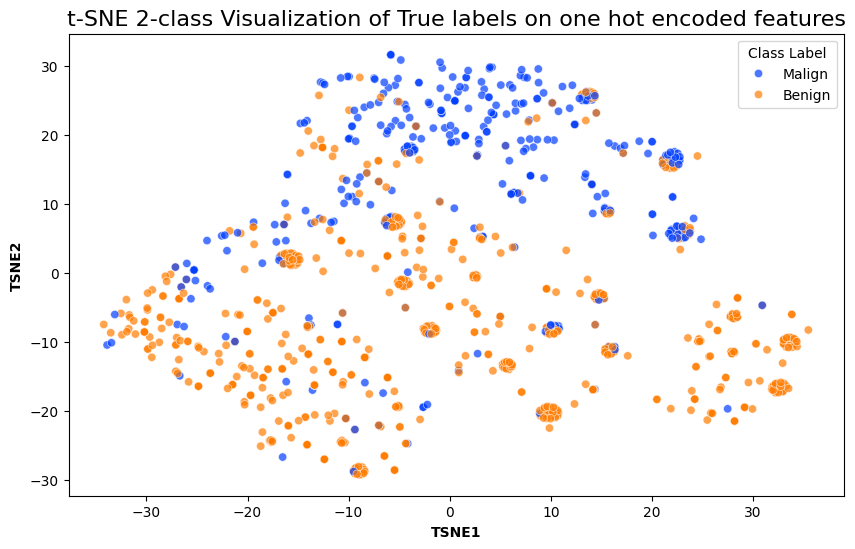

In [91]:
# Convert t-SNE results into a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_oh, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = df['Diagnosis']  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 2-class Visualization of True labels on one hot encoded features", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

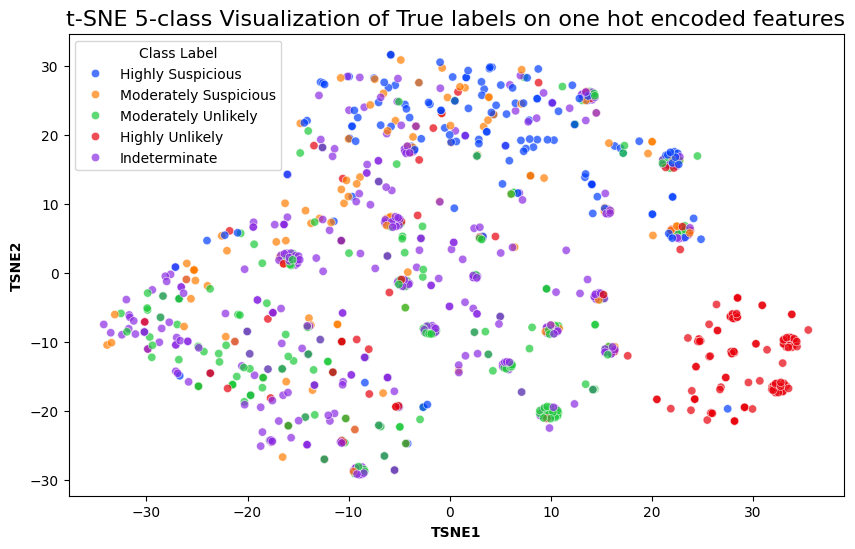

In [92]:
# Convert t-SNE results into a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_oh, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = df['Malignancy']  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 5-class Visualization of True labels on one hot encoded features", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

Now we have 4 zones: 2 gray zone with mixed values, 1 solely for the highly unlikely , 1 dominated by the highly suspicious and moderately suspicious. I would say the one-hot encoding helped separating the highly suspicious into a separate cluster more(now it has a clearly visible gap ) than on the previous chart where we treated them like numerics. But I'm, not sure because if not the space between zones which matters but rather the visual separability then the previous method performed better. So the best is to check the clustering algorithm for both 

### Removing Outliers

Makes no sense, the only numerical feature is the diameter

In [28]:
# def remove_outliers(data, quantile_range=(0.001, 0.999)):
#     """Removes outliers based on IQR method within the specified quantile range."""
#     df = data.copy()
#     Q1 = df.quantile(quantile_range[0])
#     Q3 = df.quantile(quantile_range[1])
#     IQR = Q3 - Q1
    
#     # Define lower and upper bounds for filtering
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Apply filtering to remove outliers
#     # df_cleaned = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
#     df_cleaned = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
#     # df_cleaned = df_cleaned.sort_index()
#     return df_cleaned
# df_cleaned = remove_outliers(df_filtered)
# print("✅ Data cleaned of outliers! Printing the first 5 elements")
# print(df_cleaned.shape)
# show_boxplot(df_cleaned)

### Performing unsupervised clustering on one-hot encoded data

In [84]:
# For one hot encoded data
check_clusters = [2, 5]
oh_labels_array = []
for element in check_clusters:
    c_number = element
    models = {
        "K-Means": KMeans(n_clusters=c_number, random_state=42),
        "Hierarchical (Ward)": AgglomerativeClustering(n_clusters=c_number, linkage='ward'),
        "Hierarchical (Complete)": AgglomerativeClustering(n_clusters=c_number, linkage='complete'),
        "Hierarchical (Average)": AgglomerativeClustering(n_clusters=c_number, linkage='average'),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5)  # Alternative to HyperDB (Density-based)
    }

    # Store results
    cluster_labels_oh = {}
    silhouette_scores = {}

    for name, model in models.items():
        labels = model.fit_predict(df_oh)
        cluster_labels_oh[name] = labels
        
        # Evaluate if clusters are meaningful (skip DBSCAN where n_clusters isn't defined)
        if name != "DBSCAN":
            silhouette_scores[name] = silhouette_score(df_oh, labels, metric='manhattan')

    # Print results
    print("ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters: ", element)
    for name, score in silhouette_scores.items():
        print(f"{name}: {score:.4f}")
    oh_labels_array.append(cluster_labels_oh)

ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters:  2
K-Means: 0.1720
Hierarchical (Ward): 0.1347
Hierarchical (Complete): 0.1867
Hierarchical (Average): 0.2442
ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters:  5
K-Means: 0.1733
Hierarchical (Ward): 0.1083
Hierarchical (Complete): 0.1311
Hierarchical (Average): 0.1344


### Performing unsupervised clustering on NON-one hot encoded data

In [ ]:
check_clusters = [2, 5]
labels_array = []
for element in check_clusters:
    c_number = element
    models = {
        "K-Means": KMeans(n_clusters=c_number, random_state=42),
        "Hierarchical (Ward)": AgglomerativeClustering(n_clusters=c_number, linkage='ward'),
        "Hierarchical (Complete)": AgglomerativeClustering(n_clusters=c_number, linkage='complete'),
        "Hierarchical (Average)": AgglomerativeClustering(n_clusters=c_number, linkage='average'),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5)  # Alternative to HyperDB (Density-based)
    }

    # Store results
    cluster_labels_oh = {}
    silhouette_scores = {}

    for name, model in models.items():
        labels = model.fit_predict(df_filtered2)
        cluster_labels_oh[name] = labels
        
        # Evaluate if clusters are meaningful (skip DBSCAN where n_clusters isn't defined)
        if name != "DBSCAN":
            silhouette_scores[name] = silhouette_score(df_filtered2, labels, metric='chebyshev')

    # Print results
    print("NON-ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters: ", element)
    for name, score in silhouette_scores.items():
        print(f"{name}: {score:.4f}")
    labels_array.append(cluster_labels_oh)

NON-ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters:  2
K-Means: 0.6295
Hierarchical (Ward): 0.6449
Hierarchical (Complete): 0.6346
Hierarchical (Average): 0.6254
NON-ONE HOT ENCODED DATA: Silhouette Scores (Higher = Better Clustering) for number of clusters:  5
K-Means: 0.3234
Hierarchical (Ward): 0.3103
Hierarchical (Complete): 0.3045
Hierarchical (Average): 0.1922


### Visualizing unsupervised clustering results on the t-sne graph:

#### One hot encoded, 5 clusters:

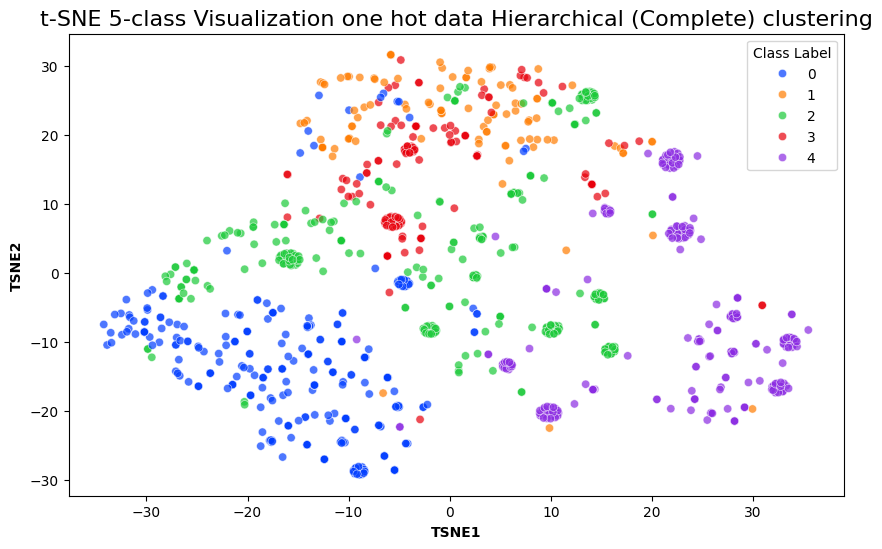

In [134]:
method = 'Hierarchical (Complete)'
# Convert t-SNE results into a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_oh, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = oh_labels_array[1][method]  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 5-class Visualization one hot data {method} clustering", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

It has a little bit of similarity with the true labels ( the 2 most suspicious and the least suspicious classes are quite close)

#### One hot encoded, 2 clusters:

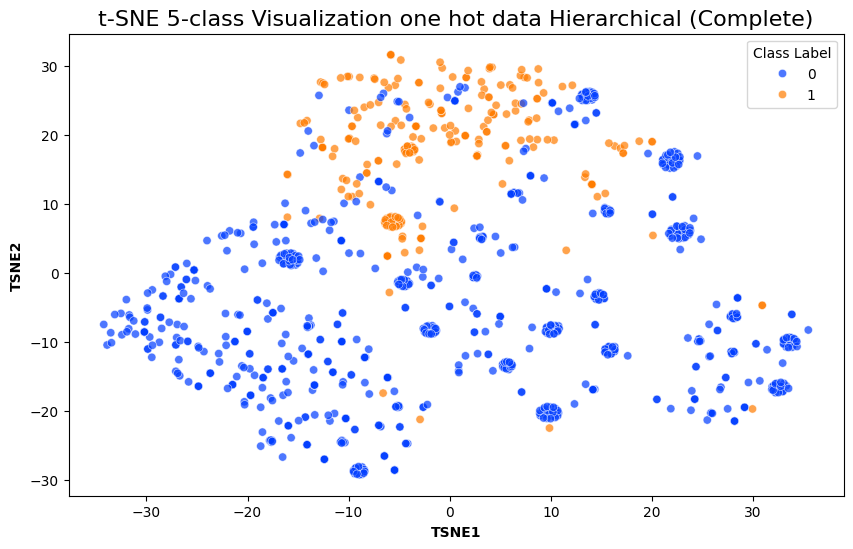

In [110]:
# Convert t-SNE results into a DataFrame for easy plotting
method = 'Hierarchical (Complete)'
tsne_df = pd.DataFrame(tsne_oh, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = oh_labels_array[0][method]  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 5-class Visualization one hot data {method}", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

This is quite similar to the true labels, where the malign class is located on the top part of the plot.

#### Non one-hot encoded data, 2 clusters

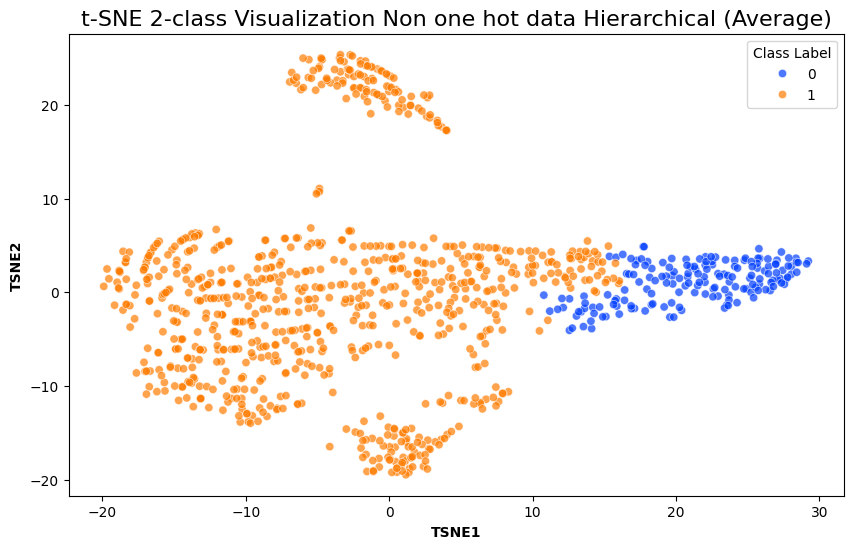

In [115]:
# Convert t-SNE results into a DataFrame for easy plotting
method = "Hierarchical (Average)"
tsne_df = pd.DataFrame(tsne_default, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = labels_array[0][method]  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 2-class Visualization Non one hot data {method}", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

THis is also similar to the the true labels, but the percentage of the classes is a bit off

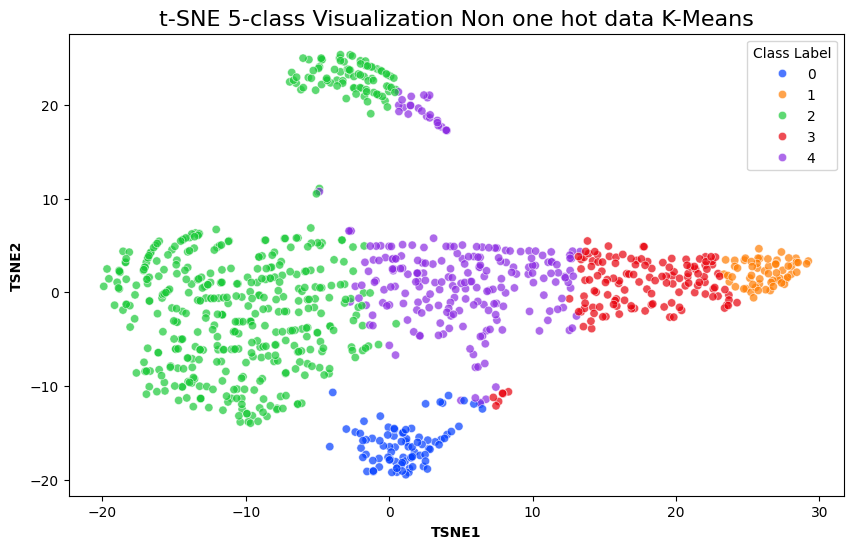

In [120]:
# Convert t-SNE results into a DataFrame for easy plotting
method = "K-Means"
tsne_df = pd.DataFrame(tsne_default, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = labels_array[1][method]  # Assuming 'Label' is your categorical class column

# Plot t-SNE with color coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], hue=tsne_df['Label'], palette='bright', alpha=0.7)

plt.title(f"t-SNE 5-class Visualization Non one hot data {method}", fontsize=16)
plt.xlabel("TSNE1", fontweight='bold')
plt.ylabel("TSNE2", fontweight='bold')
plt.legend(title="Class Label")
plt.show()

It also has some similarity with the True labels, where more obviously malignanct points are on the right side of the chart and benings are more on the left

### Clustering Conclusions

Scaling the diameter did not help the unsupervised classification's Silhouette score - this could suggest the diameter of the tumor is crucial for clustering

One hot encoding also did not help the unsupervised classification, the silhouette score got worse after one hot encoding regardless of the metric used. But it had no effect on the comparison with the true labels !!!

Increasing the number of clusters hurts the silhouette score of all unsupervised classifiers

Comparing the classes obtained from unsupervised classification with the true labels has some similarity, but the results are far from perfect



### Visualizing the hierarchical clustering dendogram for features 

For this we need to transpose the dataframe


1. Interpreting a Dendrogram for Features (Transposed DataFrame)
When you transpose your DataFrame, you're clustering radiological descriptors instead of individual records.

🔹 What does it show? It reveals how similar or redundant features are across all patient records. Features that merge at low distances in the dendrogram suggest strong correlations, meaning they may be measuring the same underlying pattern.

🔹 How to read it? ✅ Close merges at short distances → Features behave similarly across patients and might be redundant (e.g., “Margin_value” and “Spiculation_value” could measure similar traits). ✅ Long branches before merging → Features are distinct and capture unique aspects of diagnosis. ✅ Large gaps between clusters → Indicates natural feature groupings, which may suggest distinct diagnostic categories.

👉 Use case: Helps in feature selection—you can potentially drop or combine redundant features before applying diagnostic models.

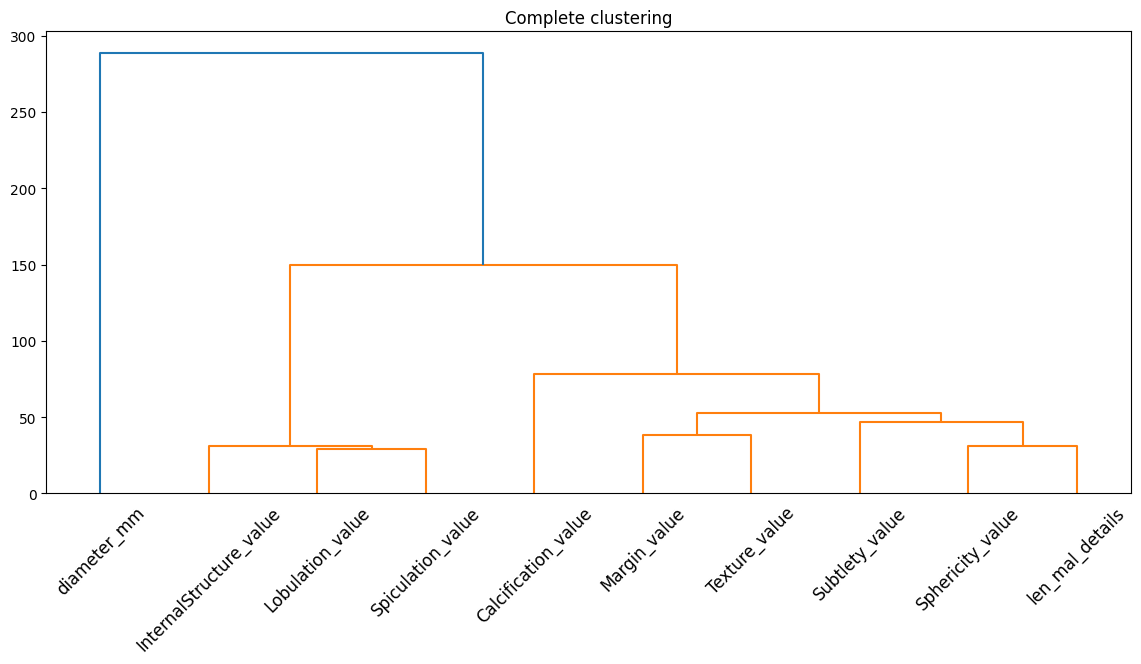

In [57]:
complete_clustering = linkage(df_filtered2.T, method="complete", metric="euclidean")
dendrogram(complete_clustering, labels=df_filtered2.T.index)
plt.title('Complete clustering')
plt.xticks(rotation=45)
plt.show()

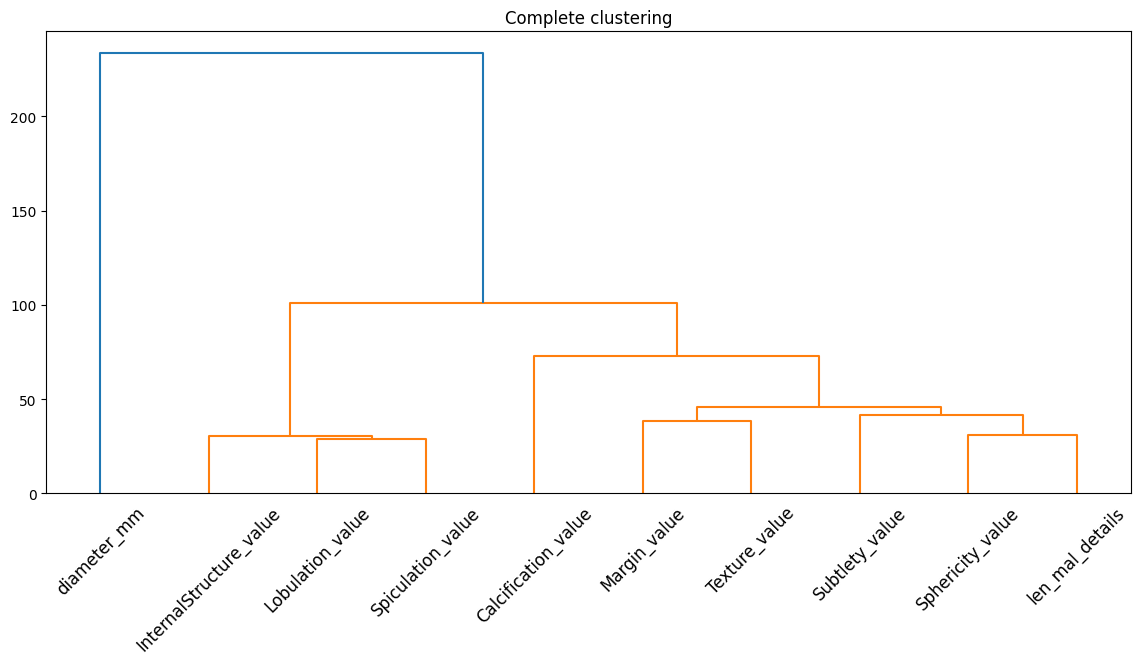

In [58]:
complete_clustering = linkage(df_filtered2.T, method="average", metric="euclidean")
dendrogram(complete_clustering, labels=df_filtered2.T.index)
plt.title('Complete clustering')
plt.xticks(rotation=45)
plt.show()

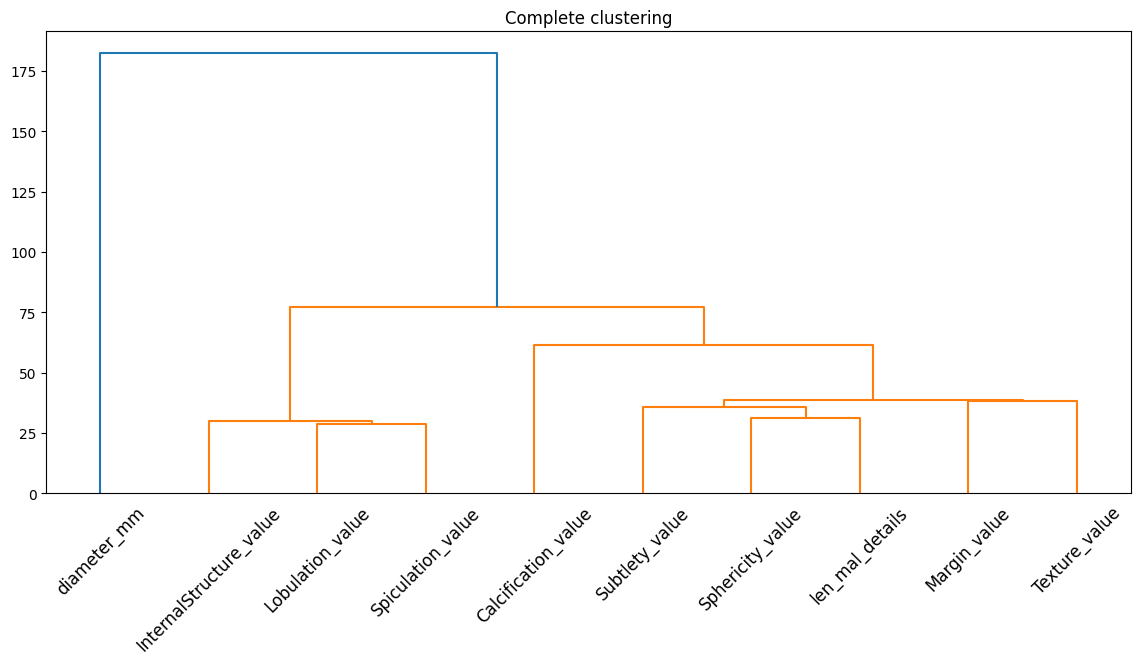

In [59]:
complete_clustering = linkage(df_filtered2.T, method="single", metric="euclidean")
dendrogram(complete_clustering, labels=df_filtered2.T.index)
plt.title('Complete clustering')
plt.xticks(rotation=45)
plt.show()

### Visualizing dendogram for indvidual records

When clustering rows (cases/patients), you're looking at similarities between patients based on radiological descriptors.

🔹 What does it show? It highlights which cases share similar characteristics, potentially grouping patients with similar diagnoses.

🔹 How to read it? ✅ Patients merging at low distances → Have similar radiological patterns, likely indicating shared pathology. ✅ Tall branches before merging → Cases are very different from each other, suggesting distinct subgroups. ✅ Clusters forming naturally → May indicate potential hidden patterns in the data, such as subtypes of a disease.

👉 Use case: Helps in diagnosis prediction—similar patient clusters may correspond to similar medical conditions, aiding in classification models.

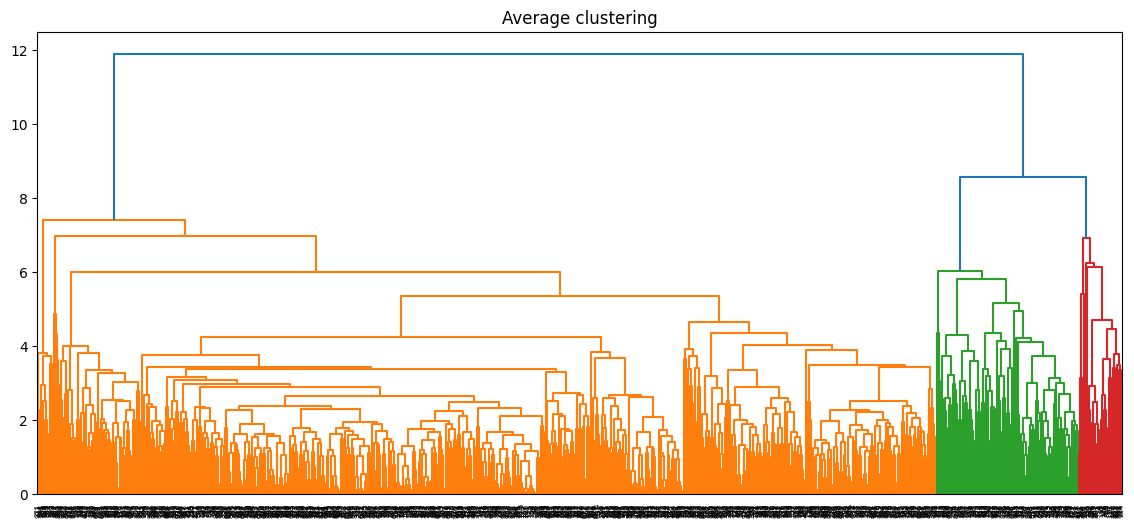

In [60]:
average_clustering = linkage(df_filtered2, method="average", metric="euclidean")
dendrogram(average_clustering)
plt.title('Average clustering')
plt.show()

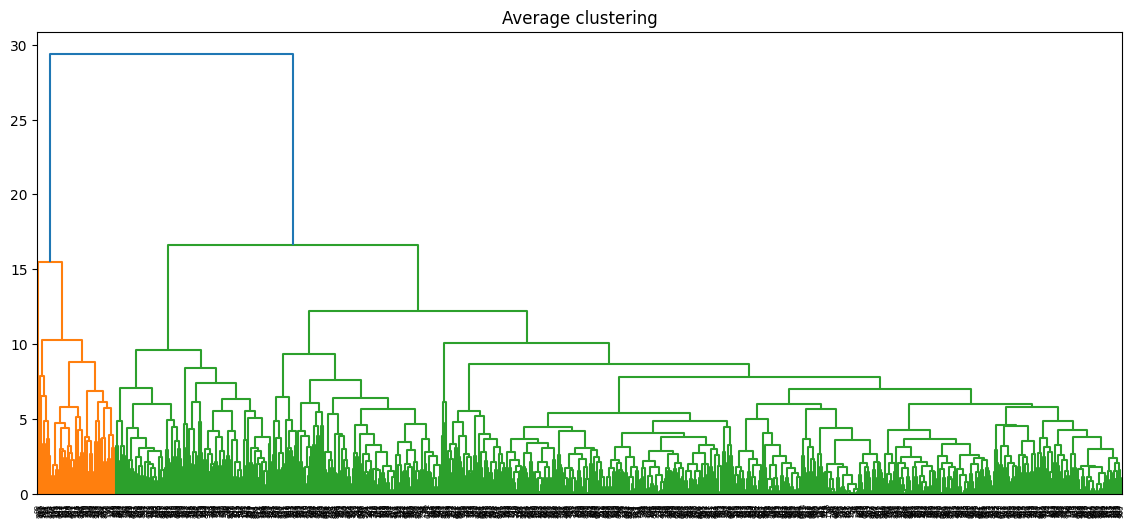

In [65]:
complete_clustering = linkage(df_filtered2, method="complete", metric="euclidean")
dendrogram(complete_clustering)
plt.title('Average clustering')
plt.show()

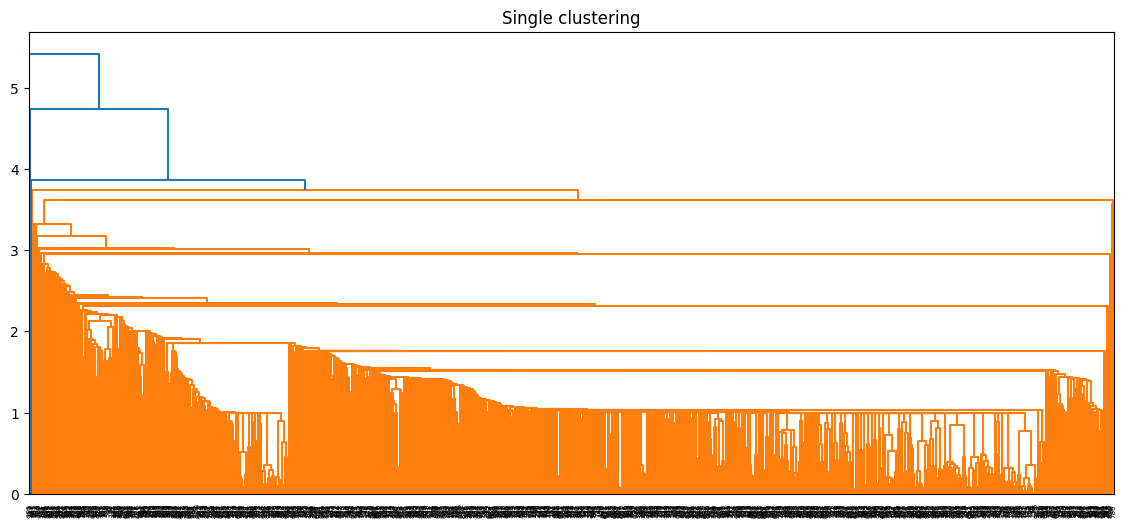

In [66]:
single_clustering = linkage(df_filtered2, method="single", metric="euclidean")
dendrogram(single_clustering)
plt.title('Single clustering')
plt.show()

### Creating correlation matrix:

No one hot encoding

In [ ]:
# Compute correlation of all annotations with the diagnosis column
df_filtered["Diagnosis_value"] = df["Diagnosis_value"]
df_filtered["Malignancy_value"]= df["Malignancy_value"]
corr_matrix = df_filtered.corr()

# Extract correlations only for the "Diagnosis" column
diagnosis_corr = corr_matrix["Diagnosis_value"].sort_values(ascending=False)

# Display the correlation values
print(diagnosis_corr)

Diagnosis_value            1.000000
diameter_mm                0.677753
Malignancy_value           0.676802
Subtlety_value             0.462431
Spiculation_value          0.401748
Lobulation_value           0.388755
len_mal_details            0.248971
Calcification_value        0.237716
InternalStructure_value    0.043452
Texture_value             -0.032577
Sphericity_value          -0.082010
Margin_value              -0.157242
Name: Diagnosis_value, dtype: float64


In [128]:
malig_corr = corr_matrix["Malignancy_value"].sort_values(ascending=False)

# Display the correlation values
print(malig_corr)

Malignancy_value           1.000000
Diagnosis_value            0.676802
diameter_mm                0.590841
Calcification_value        0.532296
Spiculation_value          0.434694
Lobulation_value           0.362660
Subtlety_value             0.235551
len_mal_details            0.120156
InternalStructure_value    0.003833
Texture_value             -0.092396
Sphericity_value          -0.120208
Margin_value              -0.253726
Name: Malignancy_value, dtype: float64


One hot encoding

In [130]:
# Compute correlation of all annotations with the diagnosis column
df_oh["Diagnosis_value"] = df["Diagnosis_value"]
df_oh["Malignancy_value"]= df["Malignancy_value"]
corr_matrix = df_oh.corr()

# Extract correlations only for the "Diagnosis" column
diagnosis_corr_oh = corr_matrix["Diagnosis_value"].sort_values(ascending=False)

# Display the correlation values
print(diagnosis_corr_oh)

Diagnosis_value              1.000000
diameter_mm                  0.677753
Malignancy_value             0.676802
Subtlety_value_5             0.477433
Spiculation_value_2          0.287130
Calcification_value_6        0.242749
Lobulation_value_3           0.240673
len_mal_details_4            0.216507
Lobulation_value_4           0.209232
Lobulation_value_2           0.204495
Spiculation_value_5          0.194818
Spiculation_value_3          0.177974
Spiculation_value_4          0.177297
Margin_value_4               0.109085
Texture_value_3              0.105832
Margin_value_3               0.090100
len_mal_details_5            0.087035
Margin_value_1               0.078401
Texture_value_4              0.076740
Sphericity_value_3           0.066820
Lobulation_value_5           0.064727
Sphericity_value_2           0.055280
InternalStructure_value_4    0.043452
len_mal_details_7            0.043452
Calcification_value_1        0.043452
len_mal_details_6            0.043452
Calcificatio

In [133]:
malig_corr_oh = corr_matrix["Malignancy_value"].sort_values(ascending=False)

# Display the correlation values
print(diagnosis_corr_oh)

Diagnosis_value              1.000000
diameter_mm                  0.677753
Malignancy_value             0.676802
Subtlety_value_5             0.477433
Spiculation_value_2          0.287130
Calcification_value_6        0.242749
Lobulation_value_3           0.240673
len_mal_details_4            0.216507
Lobulation_value_4           0.209232
Lobulation_value_2           0.204495
Spiculation_value_5          0.194818
Spiculation_value_3          0.177974
Spiculation_value_4          0.177297
Margin_value_4               0.109085
Texture_value_3              0.105832
Margin_value_3               0.090100
len_mal_details_5            0.087035
Margin_value_1               0.078401
Texture_value_4              0.076740
Sphericity_value_3           0.066820
Lobulation_value_5           0.064727
Sphericity_value_2           0.055280
InternalStructure_value_4    0.043452
len_mal_details_7            0.043452
Calcification_value_1        0.043452
len_mal_details_6            0.043452
Calcificatio

### Conclusion: 

The diameter is the most important factor in classifying the tumor, this is clearly visible on the hierarchical clustering charts and in the correlation matrixes too. 

Subtletly, Spiculation and Lobulation also play an important part for both positive and negative correlations with the outcome variables